In [1]:
# Autoreload the other files when they're changed
# We'll not be using external files for this demo, but it's generally a good idea to keep these in the notebok
%load_ext autoreload
%autoreload 2

# Linear Regression - Extra

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Data Preparation
As in the slides, we'll be trying to fit a sine function with random error

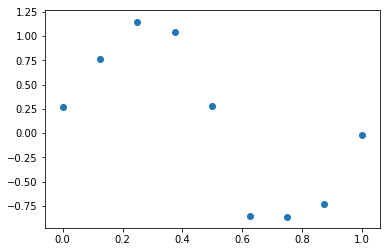

In [3]:
# Specifies the seed for generation so it's deterministic
np.random.seed(0)
num_data = 9

# Training data
x = np.linspace(0,1,num=num_data)
y = np.sin(2*np.pi*x) + np.random.randn(num_data)*0.15
# Validation data
xfit = np.linspace(0,1,1000)
yfit = np.sin(2*np.pi*xfit)
plt.scatter(x, y)

Prepare data for linear regression. If we want to use linear regression for polynomials, we need to first compute the polynomials.

If we want to fit a n-th order polynomial, we first need to compute $x^n$, $x^{n-1}$, ..., $x^0$

In [4]:
M=3
x_poly = np.zeros((num_data, M+1))
for i in range(M+1):
    x_poly[:,i] = x**i

This time we're using numpy's ``linalg`` library

Training loss: 0.03403798955499544; validation loss: 0.031610917350366245


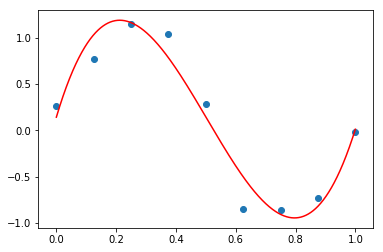

In [5]:
coef,loss_train,_,_ = np.linalg.lstsq(x_poly, y, rcond=None)
# Calculate training loss
y_train = np.matmul(x_poly, coef)
loss_train = np.mean((y_train-y)**2)

xfit_poly = np.zeros((1000, M+1))
for i in range(M+1):
    xfit_poly[:,i] = xfit**i
yfit_train = np.matmul(xfit_poly, coef)
# Calculate validation loss
loss_val = np.mean((yfit_train-yfit)**2)
plt.scatter(x, y)
plt.plot(xfit, yfit_train, 'r')
print("Training loss: {0}; validation loss: {1}".format(loss_train, loss_val))

### Effect of overfitting

Training loss: 0.03403798955499544; validation loss: 0.031610917350366245


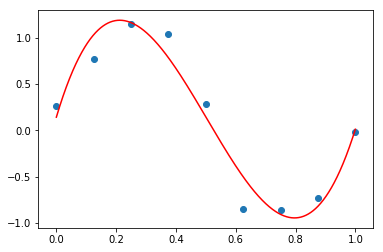

In [6]:
# Increase M and see the effect on training and validation loss
M=3
def train_lstsq_val(x, y, xfit, yfit, M):
    num_data = np.shape(x)[0]
    x_poly = np.zeros((num_data, M+1))
    for i in range(M+1):
        x_poly[:,i] = x**i
    coef,_,_,_ = np.linalg.lstsq(x_poly, y, rcond=None)
    # Calculate training loss
    y_train = np.matmul(x_poly, coef)
    loss_train = np.mean((y_train-y)**2)

    num_data_val = np.shape(xfit)[0]
    xfit_poly = np.zeros((num_data_val, M+1))
    for i in range(M+1):
        xfit_poly[:,i] = xfit**i
    yfit_train = np.matmul(xfit_poly, coef)
    # Calculate validation loss
    loss_val = np.mean((yfit_train-yfit)**2)
    return coef, loss_train, loss_val, yfit_train

coef, loss_train, loss_val, yfit_train = train_lstsq_val(x, y, xfit, yfit, M)
plt.scatter(x, y)
plt.plot(xfit, yfit_train, 'r')
print("Training loss: {0}; validation loss: {1}".format(loss_train, loss_val))

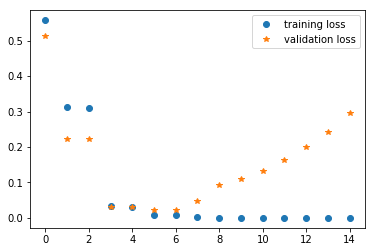

In [7]:
# Plot training & validataion loss vs order M
# Be reasonable with M size (Don't try something like 10,000)
losses_train = []
losses_val = []
M_values = list(range(15))
for M in M_values:
    _, loss_train, loss_val, _ = train_lstsq_val(x, y, xfit, yfit, M)
    losses_train.append(loss_train)
    losses_val.append(loss_val)
plt.plot(M_values, losses_train, 'o', M_values, losses_val, '*')
plt.legend(["training loss", "validation loss"])

### Fighting overfitting

More training data

Training loss: 1.3595984050365571e-24; validation loss: 0.10997630327674096


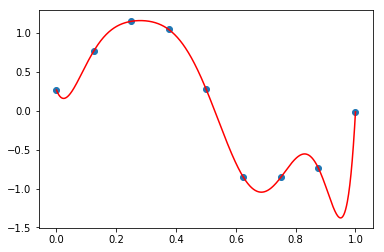

In [8]:
# Increase the number of training data points and M. Pick M>=9 so that it was previously overfitting
num_data = 9
M = 9
np.random.seed(0)
x = np.linspace(0,1,num=num_data)
y = np.sin(2*np.pi*x) + np.random.randn(num_data)*0.15
coef, loss_train, loss_val, yfit_train = train_lstsq_val(x, y, xfit, yfit, M)
plt.scatter(x, y)
plt.plot(xfit, yfit_train, 'r')
print("Training loss: {0}; validation loss: {1}".format(loss_train, loss_val))

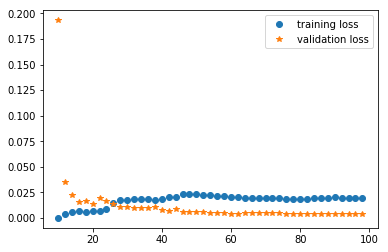

In [9]:
# Plot training & validation loss vs order M
losses_train = []
losses_val = []
num_datas = list(range(10,100,2))
for num_data in num_datas:
    np.random.seed(0)
    x = np.linspace(0,1,num=num_data)
    y = np.sin(2*np.pi*x) + np.random.randn(num_data)*0.15
    _, loss_train, loss_val, _ = train_lstsq_val(x, y, xfit, yfit, M)
    losses_train.append(loss_train)
    losses_val.append(loss_val)
plt.plot(num_datas, losses_train, 'o', num_datas, losses_val, '*')
plt.legend(["training loss", "validation loss"])

### Regularization

L2 regularization (penalizing large coefficients)

More information can be found here: https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization

(or if you just search for the term)

Training loss: 1.5198174918991095e-23; validation loss: 0.09353476653075513


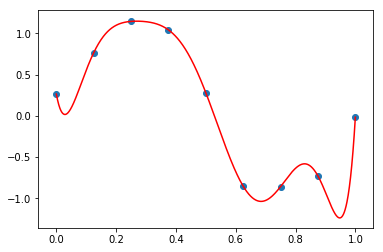

In [10]:
# Modify l2 value to increase strength of regularization. You may need very large l2 to see an effect
num_data = 9
M = 8
l2 = 0
def train_lstsq_val_l2(x, y, xfit, yfit, M, l2=0):
    num_data = np.shape(x)[0]
    # Adding L2 regularization for linear regression is equivalent to adding a data point [1,1,1,...] and let it fit to 0
    # You will learn about it if you take any machine learning course
    x_poly = np.zeros((num_data+1, M+1))
    x_poly[-1] = l2*num_data
    y_expand = np.zeros(num_data+1)
    y_expand[:-1] = y
    
    for i in range(M+1):
        x_poly[:-1,i] = x**i
    coef,sth,_,_ = np.linalg.lstsq(x_poly, y_expand, rcond=None)
    # Calculate training loss
    y_train = np.matmul(x_poly, coef)
    y_train = y_train[:-1]
    loss_train = np.mean((y_train-y)**2)

    num_data_val = np.shape(xfit)[0]
    xfit_poly = np.zeros((num_data_val, M+1))
    for i in range(M+1):
        xfit_poly[:,i] = xfit**i
    yfit_train = np.matmul(xfit_poly, coef)
    # Calculate validation loss
    loss_val = np.mean((yfit_train-yfit)**2)
    return coef, loss_train, loss_val, yfit_train


np.random.seed(0)
x = np.linspace(0,1,num=num_data)
y = np.sin(2*np.pi*x) + np.random.randn(num_data)*0.15
coef, loss_train, loss_val, yfit_train = train_lstsq_val_l2(x, y, xfit, yfit, M, l2)
plt.scatter(x, y)
plt.plot(xfit, yfit_train, 'r')
print("Training loss: {0}; validation loss: {1}".format(loss_train, loss_val))

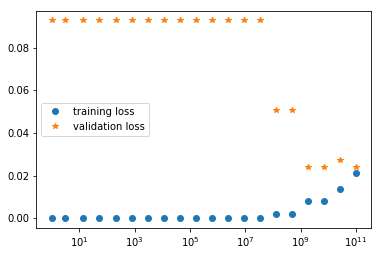

In [11]:
# Plot training & validation loss vs regularization strength l2
losses_train = []
losses_val = []
l2s = np.logspace(0, 11, num=20, endpoint=True, dtype=int)
for l2 in l2s:
    np.random.seed(0)
    x = np.linspace(0,1,num=num_data)
    y = np.sin(2*np.pi*x) + np.random.randn(num_data)*0.15
    _, loss_train, loss_val, _ = train_lstsq_val_l2(x, y, xfit, yfit, M, l2)
    losses_train.append(loss_train)
    losses_val.append(loss_val)
plt.plot(l2s, losses_train, 'o', l2s, losses_val, '*')
plt.xscale('log')
plt.legend(["training loss", "validation loss"])